## Preparing the env
- First we need to install cartopy in our conda env
- Then we install the rest of the required libs

In [ ]:
!conda install -y -c python3 cartopy
!pip install geoplot pygeohash geopy shapely geos geopandas descartes 

## Loading and preparing the dataframes

In [1]:
%matplotlib inline
from geopy import distance as geodist
import pygeohash as pgh
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import base64
from shapely.geometry import Point, Polygon

In [2]:
date_parser = lambda x: pd.to_datetime(x)

In [3]:
!aws s3 sync s3://aws-ml-blog/artifacts/using-ml-to-predict-vessel-arrival-time-sagemaker/data/ data/

download: s3://aws-ml-blog/artifacts/using-ml-to-predict-vessel-arrival-time-sagemaker/data/portcalls.csv to data/portcalls.csv
download: s3://aws-ml-blog/artifacts/using-ml-to-predict-vessel-arrival-time-sagemaker/data/checkpoints.csv to data/checkpoints.csv


In [4]:
df_port = pd.read_csv('data/portcalls.csv', parse_dates=['arrival_date', 'departure_date'], date_parser=date_parser)
df_port.head(2)

,imo,arrival_date,departure_date,port
0,0,2019-01-07,2019-01-08,GUAM
1,0,2019-01-11,2019-01-12,NAHA


In [5]:
df_checkpoint = pd.read_csv('data/checkpoints.csv', parse_dates=['timestamp_position', 'position_date'], date_parser=date_parser)
geometry = [Point(xy) for xy in zip(df_checkpoint.lon, df_checkpoint.lat)]
df_checkpoint = gpd.GeoDataFrame(df_checkpoint, geometry=geometry)
df_checkpoint.head(2)

,imo,timestamp_position,position_date,shiptype,dimA,dimB,draught,destination,lat,lon,heading,course,aisshiptype,geometry
0,0,2019-01-01 22:44:13+00:00,2019-01-01,1,143,74,10.0,GUAM,18.5195,-167.327833,220.0,219.0,0,POINT (-167.32783 18.51950)
1,0,2019-01-02 00:03:01+00:00,2019-01-02,1,143,74,10.0,GUAM,18.5295,-167.785333,270.0,337.0,0,POINT (-167.78533 18.52950)


### Left join between the DataFrames by vessel and pos date(arr, dep)

In [6]:
# Left join with PORTS dataframe to get the arrival & departure events
df_dataset = pd.merge(
    df_checkpoint, df_port[['imo', 'port', 'arrival_date']], 
    how='left', left_on=['imo','position_date'], right_on = ['imo','arrival_date']
)
df_dataset = pd.merge(
    df_dataset, df_port[['imo', 'port', 'departure_date']], 
    how='left', left_on=['imo','position_date'], right_on = ['imo','departure_date']
)
df_dataset.head(2)

,imo,timestamp_position,position_date,shiptype,dimA,dimB,draught,destination,lat,lon,heading,course,aisshiptype,geometry,port_x,arrival_date,port_y,departure_date
0,0,2019-01-01 22:44:13+00:00,2019-01-01,1,143,74,10.0,GUAM,18.5195,-167.327833,220.0,219.0,0,POINT (-167.32783 18.51950),NaN,NaT,NaN,NaT
1,0,2019-01-02 00:03:01+00:00,2019-01-02,1,143,74,10.0,GUAM,18.5295,-167.785333,270.0,337.0,0,POINT (-167.78533 18.52950),NaN,NaT,NaN,NaT


### Let's compute some new features
- Distance (circular) between two checkpoints
- Efficiency of the vessel: distance per time
- Elapsed time from one checkpoint to the current
- Geohash to encode the lat/lon reported by the vessel

In [7]:
%%time
# Iterate to compute distances between each two timestamps, plus compute geohashes
prev_row = None
shipping_id = 0
shipping_ids = [shipping_id]
distance = [0]
efficiency = [pd.Timedelta('0 days')]
elapsed_time = [0]
geohash = []
for idx,row in df_dataset.iterrows():
    # encode the geo location    
    geohash.append( pgh.encode(row.lat, row.lon, precision=4))
    if prev_row is None:
        prev_row = row
        continue    
    if row.destination != prev_row.destination:        
        shipping_id += 1
    # compute the distance between the previous checkpoint and the current one
    distance_per_segment = geodist.distance((row.lat, row.lon), (prev_row.lat, prev_row.lon)).kilometers
    distance.append(distance_per_segment)
    # compute the elapsed time between checkpoints
    if prev_row.imo == row.imo:
        elapsed_time_per_segment = row.timestamp_position - prev_row.timestamp_position
        if elapsed_time_per_segment.total_seconds() < 0:
            print("ERROR")
    else:
        elapsed_time_per_segment = pd.Timedelta('0 days')    
    elapsed_time.append(elapsed_time_per_segment)
    # compute the efficiency, based on the traversed distance per time    
    if elapsed_time_per_segment.total_seconds() > 0:        
        efficiency.append(distance_per_segment/(elapsed_time_per_segment.total_seconds()))
    else:
        efficiency.append(0.0)
    shipping_ids.append(shipping_id)
    prev_row = row

df_dataset['dist'] = distance
df_dataset['efficiency'] = efficiency
df_dataset['elapsed_time'] = elapsed_time
df_dataset['shipping_id'] = shipping_ids
df_dataset['geohash'] = geohash

CPU times: user 9.2 s, sys: 2.91 ms, total: 9.21 s
Wall time: 9.2 s


### Now we go backwards and compute
- Accumulated distance from the destination to the origin
- Accumulated time from the destination to the orign (this is the label)
- Propagate the destination port across all the checkpoints of a given vessel voyage

In [8]:
%%time
# Now compute the accumulated distance for each shipping
destination_port = None
destination_ports = []
accum_dist = []
accum_time = []
shipping_accum_dist = 0
shipping_accum_time = pd.Timedelta('0 days')
status = 0
prev_status = 0
for idx in reversed(df_dataset.index):
    row = df_dataset.iloc[idx]
    if pd.notnull(row.arrival_date): # arrival
        shipping_accum_dist = 0
        shipping_accum_time = pd.Timedelta('0 days')
        destination_port = row.port_x        
        status = 1
    
    destination_ports.append(destination_port)
    if pd.notnull(row.departure_date): # departure        
        status = 0
        destination_port = None
    accum_dist.append(shipping_accum_dist) 
    accum_time.append(shipping_accum_time)
    if status == 1:
        shipping_accum_dist += row.dist
        if row.elapsed_time != 0:
            shipping_accum_time += row.elapsed_time
    prev_status = status

df_dataset['accum_dist'] = list(reversed(accum_dist))
df_dataset['accum_time'] = list(reversed(accum_time))
df_dataset['destination_port'] = list(reversed(destination_ports))

CPU times: user 4.21 s, sys: 3.94 ms, total: 4.22 s
Wall time: 4.22 s


### Now, let's propagate the origin port across the checkpoints of the vessel voyage

In [9]:
origin_port = None
origin_ports = []
for idx,row in df_dataset.iterrows():
    if pd.notnull(row.port_x):
        origin_port = row.port_x   
    origin_ports.append(origin_port)
df_dataset['origin_port'] = origin_ports

### And clean the invalid Vessel Voyages (without arrival)

In [10]:
df_dataset = df_dataset.drop(
    df_dataset[pd.isnull(df_dataset.destination_port)|pd.isnull(df_dataset.origin_port)].index
).reset_index()

## Ok, let's take a look on the vessel voyages of a given imo

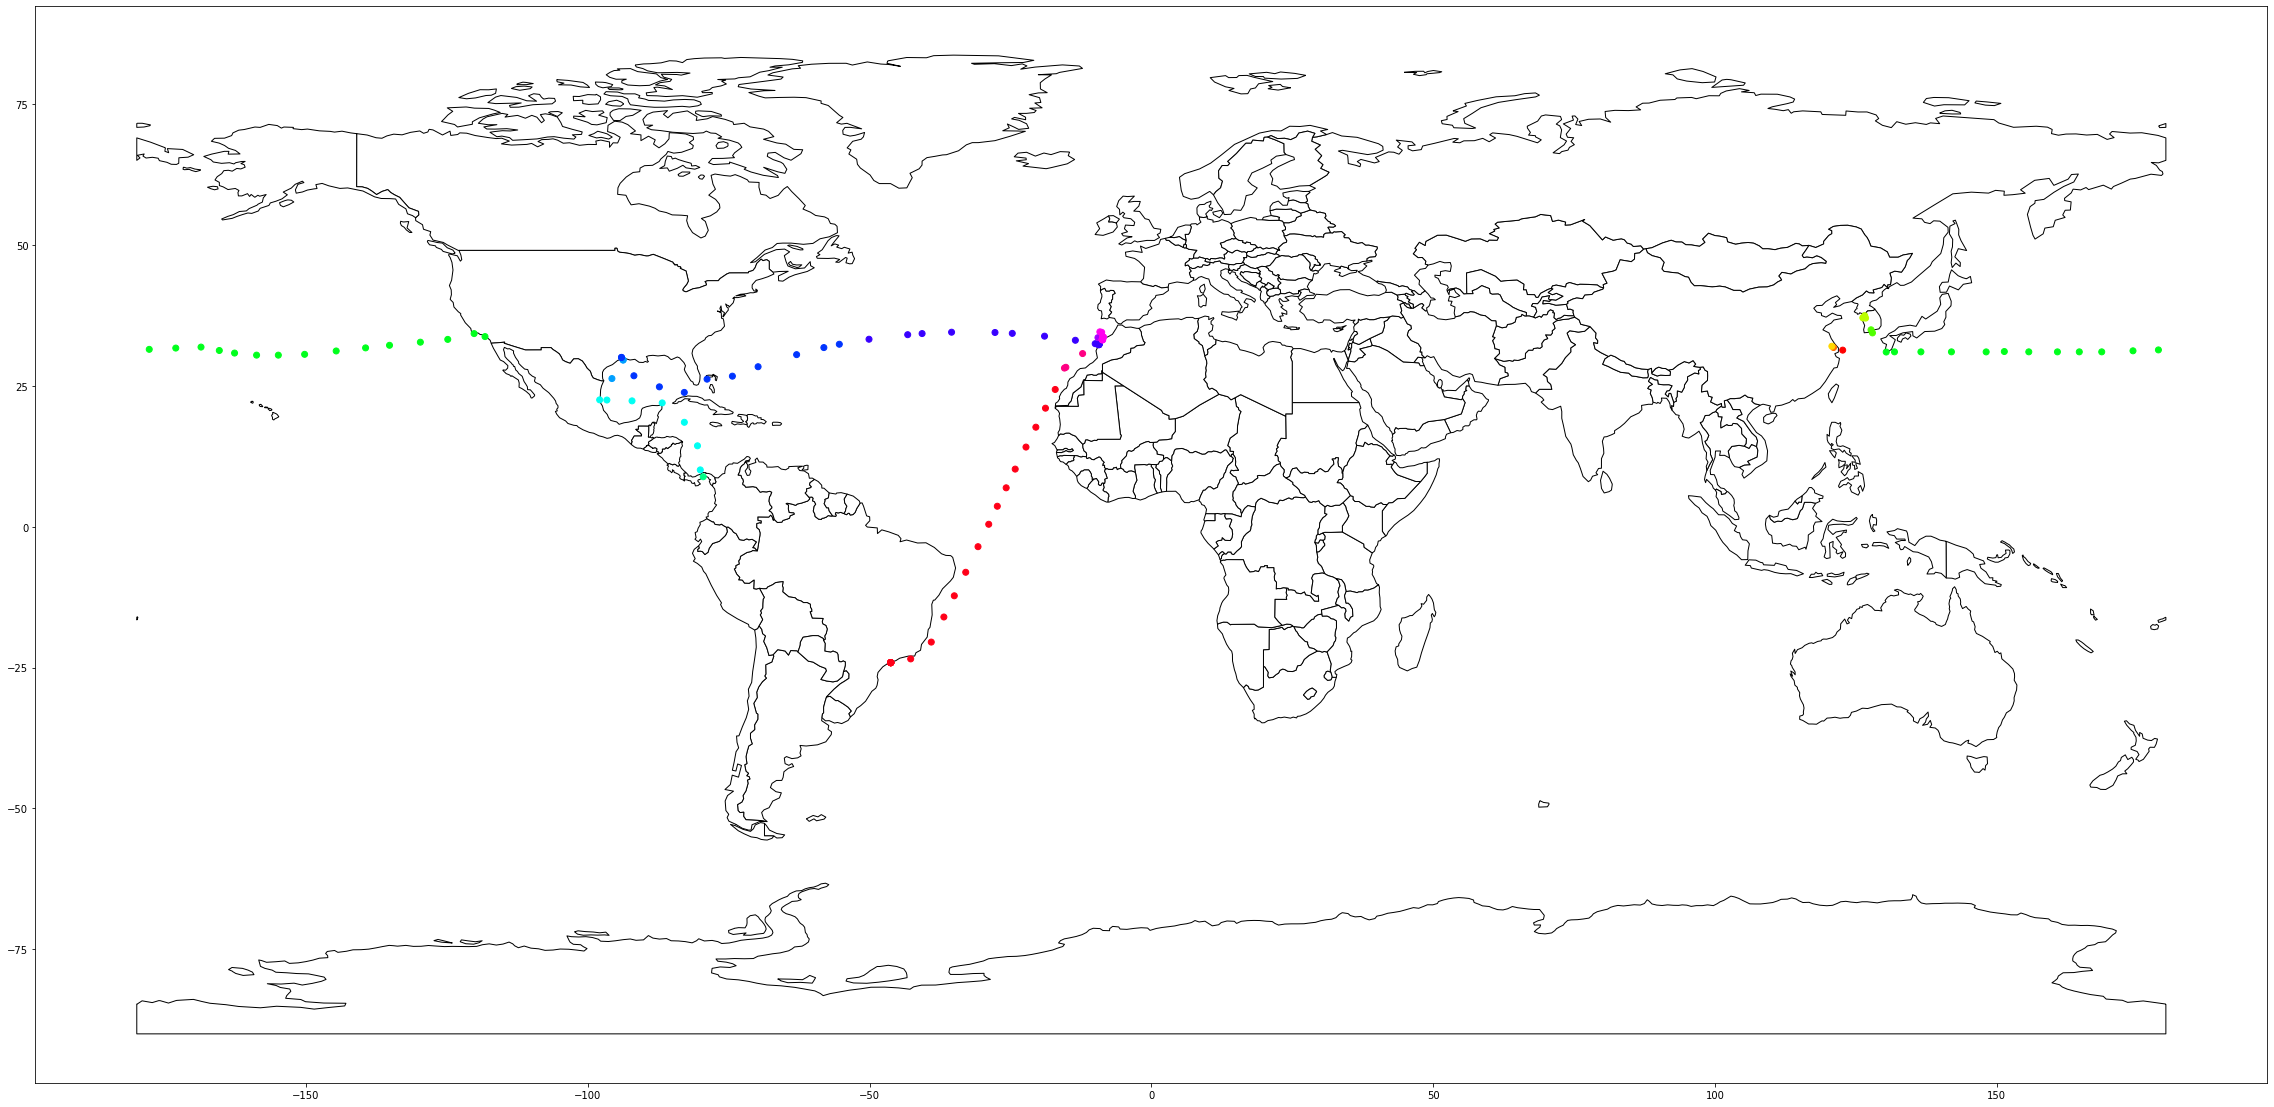

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(40,60))
# We can now plot our ``GeoDataFrame``.
df_tmp = df_dataset[(df_dataset.imo == 97)]
ids = {a:i for i,a in enumerate(df_tmp.shipping_id.unique())}
cmap = plt.cm.get_cmap('hsv', len(ids))
colors = df_tmp.shipping_id.apply(lambda x: matplotlib.colors.rgb2hex(cmap(ids[x])))


#minx, miny, maxx, maxy = df_tmp.total_bounds
#ax.set_xlim(-60, -40)
#ax.set_ylim(miny, -20)

df_tmp.plot(ax=ax, color=colors)

## Now, let's prepare our dataset
- Let's convert the types, clean and select the best features (using feature importance + SHAP)

In [12]:
df_train = df_dataset.copy()

df_train.loc[:,'accum_time'] = df_dataset.accum_time.dt.total_seconds() / (60 * 60 * 24) # days
df_train.loc[:,'origin_port'] = df_dataset.origin_port.astype('category').cat.codes
df_train.loc[:,'destination_port'] = df_dataset.destination_port.astype('category').cat.codes
df_train.loc[:,'geohash'] = df_dataset.geohash.astype('category').cat.codes
df_train.loc[:,'aisshiptype'] = df_dataset.aisshiptype.astype('category').cat.codes
df_train.loc[:,'shiptype'] = df_dataset.shiptype.astype('category').cat.codes
df_train.loc[:,'delta_orientation'] = df_dataset.course - df_dataset.heading
df_train.loc[:,'efficiency'] = df_dataset.efficiency.astype(np.float64)

# keep only the important features
df_train = df_train[[
    'accum_time', 'accum_dist', 'efficiency', 'geohash', 'shiptype', 'dimB', 'draught',
    'destination_port', 'dimA', 'origin_port'
]]
df_train.to_csv('data/train.csv', sep=',', header=None, index=None)
df_train.head()

,accum_time,accum_dist,efficiency,geohash,shiptype,dimB,draught,destination_port,dimA,origin_port
0,0.000000,0.000000,0.009117,5217,1,74,10.0,51,143,51
1,3.454988,2264.432050,0.000000,5217,1,74,10.0,115,143,51
2,2.582269,1959.171581,0.004048,5225,1,74,9.1,115,143,51
3,1.373183,1100.031040,0.008224,5232,1,74,9.1,115,143,51
4,0.000000,0.000000,0.009272,4660,1,74,9.1,115,143,115


In [13]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,accum_time,accum_dist,efficiency,geohash,shiptype,dimB,draught,destination_port,dimA,origin_port
accum_time,1.000000,0.842992,0.077093,-0.068177,-0.019338,-0.103888,0.031177,-0.003153,0.043416,0.009026
accum_dist,0.842992,1.000000,0.206217,-0.074528,-0.052761,-0.062918,0.119926,-0.019320,0.069234,-0.000025
efficiency,0.077093,0.206217,1.000000,-0.070558,-0.078633,-0.008750,0.242450,-0.095961,0.056557,-0.029087
geohash,-0.068177,-0.074528,-0.070558,1.000000,0.000582,0.031897,-0.054192,0.085374,0.015282,0.088133
shiptype,-0.019338,-0.052761,-0.078633,0.000582,1.000000,0.159430,-0.357479,-0.001013,-0.534008,0.000412
dimB,-0.103888,-0.062918,-0.008750,0.031897,0.159430,1.000000,0.277465,0.025013,-0.719441,0.053486
draught,0.031177,0.119926,0.242450,-0.054192,-0.357479,0.277465,1.000000,-0.018165,0.135649,0.098463
destination_port,-0.003153,-0.019320,-0.095961,0.085374,-0.001013,0.025013,-0.018165,1.000000,0.025606,0.290837
dimA,0.043416,0.069234,0.056557,0.015282,-0.534008,-0.719441,0.135649,0.025606,1.000000,-0.000691
origin_port,0.009026,-0.000025,-0.029087,0.088133,0.000412,0.053486,0.098463,0.290837,-0.000691,1.000000
